In [8]:
from pathlib import Path
import os
import sys

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [9]:
matplotlib.use('Agg')
%matplotlib inline

In [ ]:
# forest.jpg
# apple.jpg
def test_orb(src:os.PathLike, nfeatures:int, debug=False):
    
    img = cv2.imread(src)
            
    # blur된 이미지를 gray로 변환 (바로 gray로 변환하지 않음)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)  
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)     
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB()
    orb = orb.create(
        nfeatures=nfeatures, # 상위 몇개의 특징점을 사용할 것인지
        scaleFactor=1.2, 
        nlevels=8,
        edgeThreshold=15, # edgeThreshold와 patchSize는 서로 비례해야 함. edgeThreshold는 제외할 이미지 경계에 사용되는 값
        # Backgroud image는 이 값을 줄여야 함.
        firstLevel=0,
        WTA_K=2, # BRIEF descriptor가 사용할 bit 가짓수. binary이므로 1bit임.
        scoreType=cv2.ORB_HARRIS_SCORE, 
        patchSize=31, # edgeThreshold와 크거나 같은 값으로 설정해야 함.
        fastThreshold=10, # FAST detector에서 근처 픽셀들이 얼마나 밝거나 어두워야 하는지에 대한 임계값
    )

    kp1, _ = orb.detectAndCompute(gray, None)
    
    def non_max_suppression(keypoints, min_distance=5):
        keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)
        selected = []
        for kp in keypoints:            
            if any(distance(kp, s) < min_distance for s in selected):
                continue
            selected.append(kp)
        return selected

    def distance(kp1, kp2):
        return np.sqrt((kp1.pt[0] - kp2.pt[0])**2 + (kp1.pt[1] - kp2.pt[1])**2)
    
    kp1 = non_max_suppression(kp1)
    if debug:
        result = img.copy()
        for kp in kp1:
            x, y = kp.pt
            cv2.circle(result, (int(x), int(y)), 1, (255, 0, 0), -1)
            
        plt.imshow(result)
        plt.title('object image orb')
        plt.show()
    print(f"total keypoints: {len(kp1)}")
    
    return img, kp1
    
                 
test_orb(src="apple.jpg", nfeatures=300, debug=True)

In [ ]:
def test_harris(threshold=0.01):
    """
    Threshold should be tuned.
    """
    src = cv2.imread("apple.jpg")
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    dst = cv2.cornerHarris(
        gray,
        blockSize=2, # 이웃 픽셀의 크기
        ksize=3, # Sobel 미분 커널의 크기
        k=0.04 # 해리스 코너 검출 상수    
    )
    # dst = cv2.dilate(dst, None) # 팽창 연산을 통해 코너 검출 결과를 표시하기 좋게 만듦.
    
    # threshold = 0.01
    src[dst > threshold * dst.max()] = [255, 0, 0]  # dst.max()에서 1% 이상의 값만 파란색으로 표시.
    
    plt.imshow(src)
    plt.title('my picture')
    plt.show()    


test_harris()

In [ ]:
def test_canny():
    src = cv2.imread("apple.jpg")    
    canny = cv2.Canny(src, 60, 200)    
    contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contour_image =  cv2.drawContours(src, contours, -1, (255, 0, 0), 1)
    plt.imshow(contour_image)
    plt.title('my picture')
    plt.show()
    


test_canny()

In [ ]:
# 가장 큰 윤곽선 읽기.
def test_contour():
    # 이미지 읽기
    image = cv2.imread('apple.jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 윤곽선 추출
    edges = cv2.Canny(gray, 50, 150)
    # 외곽 윤곽선만 찾기
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 결과 이미지 생성
    result = np.zeros_like(image)

    # 가장 큰 윤곽선 찾기 (일반적으로 이것이 외곽 윤곽선)
    largest_contour = max(contours, key=cv2.contourArea)

    # 윤곽선 단순화
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # 단순화된 윤곽선의 점들을 일정 간격으로 추출
    for i in range(0, len(approx), 1):  # 5는 간격을 조절하는 파라미터
        cv2.circle(result, tuple(approx[i][0]), 2, (0, 255, 0), -1)
    
    plt.imshow(result)
    plt.title('my picture')
    plt.show()

test_contour()

In [ ]:

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import time

# forest.jpg
# apple.jpg

def non_max_suppression(keypoints, min_distance=5):
        keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)        
        selected = []
        for kp in keypoints:            
            if any(distance(kp, s) < min_distance for s in selected):
                continue                        
            selected.append(kp)        
                
        return selected

def distance(kp1, kp2):
    return np.sqrt((kp1.pt[0] - kp2.pt[0])**2 + (kp1.pt[1] - kp2.pt[1])**2)

def object_orb(src:os.PathLike, nfeatures:int, debug=False):
    """
    removebg 처리하니 edgeThreshold 높아도 좋음.
    얇은 구조에 대해서 너무 많은 특징점이 검출되는 것을 방지하기 위해(clustering) non-maximum suppression을 사용함.
    nfeature에 따라 너무 적은 특징점이 나오는 경우 존재.
    """
    img = cv2.imread(src)
            
    # blur된 이미지를 gray로 변환 (바로 gray로 변환하지 않음)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)  
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)     
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB()
    orb = orb.create(
        nfeatures=nfeatures, # 상위 몇개의 특징점을 사용할 것인지
        scaleFactor=1.2, 
        nlevels=8,
        edgeThreshold=15, # edgeThreshold와 patchSize는 서로 비례해야 함. edgeThreshold는 제외할 이미지 경계에 사용되는 값
        # Backgroud image는 이 값을 줄여야 함.
        firstLevel=0,
        WTA_K=2, # BRIEF descriptor가 사용할 bit 가짓수. binary이므로 1bit임.
        scoreType=cv2.ORB_HARRIS_SCORE, 
        patchSize=31, # edgeThreshold와 크거나 같은 값으로 설정해야 함.
        fastThreshold=10, # FAST detector에서 근처 픽셀들이 얼마나 밝거나 어두워야 하는지에 대한 임계값
    )

    kp1, _ = orb.detectAndCompute(gray, None)        
    
    kp1 = non_max_suppression(kp1)
    if debug:
        result = img.copy()
        for kp in kp1:
            x, y = kp.pt
            cv2.circle(result, (int(x), int(y)), 1, (255, 0, 0), -1)
            
        plt.imshow(result)
        plt.title('object image orb')
        plt.show()
    print(f"total keypoints: {len(kp1)}")
    
    return img, kp1
    

def background_orb(src:os.PathLike, nfeatures:int, debug=False):
    """
    많은 특징점이 필요함.
    """
    img = cv2.imread(src)
            
    # blur된 이미지를 gray로 변환 (바로 gray로 변환하지 않음)
    blurred = cv2.GaussianBlur(img, (5, 5), 0)  
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)     
    
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB()
    orb = orb.create(
        nfeatures=nfeatures, # 상위 몇개의 특징점을 사용할 것인지
        scaleFactor=1.2, 
        nlevels=8,
        edgeThreshold=15, # edgeThreshold와 patchSize는 서로 비례해야 함. edgeThreshold는 제외할 이미지 경계에 사용되는 값
        # Backgroud image는 이 값을 줄여야 함.
        firstLevel=0,
        WTA_K=2, # BRIEF descriptor가 사용할 bit 가짓수. binary이므로 1bit임.
        scoreType=cv2.ORB_HARRIS_SCORE, 
        patchSize=15, # edgeThreshold와 크거나 같은 값으로 설정해야 함.
        fastThreshold=10, # FAST detector에서 근처 픽셀들이 얼마나 밝거나 어두워야 하는지에 대한 임계값
    )

    kp1, _ = orb.detectAndCompute(gray, None)        
    
    kp1 = non_max_suppression(kp1, min_distance=3)
    if debug:
        result = img.copy()
        for kp in kp1:
            x, y = kp.pt
            cv2.circle(result, (int(x), int(y)), 1, (255, 0, 0), -1)
            
        plt.imshow(result)
        plt.title('object image orb')
        plt.show()
    print(f"back keypoints: {len(kp1)}")
    
    return img, kp1
    
                 
obj_img, obj_kp = object_orb(src="apple.jpg", nfeatures=200, debug=True)
back_img, back_kp = background_orb(src="forest.jpg", nfeatures=1000, debug=True)

# 현재 PCA 하기 전에 scaling하지 않았음.
pca = PCA(n_components=2)
pca_obj_kp = pca.fit_transform(np.array([kp.pt for kp in obj_kp]))


def calculate_max_distance(pca_points):
    # 각 점에서 다른 모든 점까지의 벡터 계산
    diff = pca_points[:, np.newaxis, :] - pca_points[np.newaxis, :, :]    
    
    # 거리의 제곱 계산
    squared_distances = np.sum(diff**2, axis=-1)    
    
    # 대각선(자기 자신과의 거리)을 제외하고 최대값 찾기
    max_squared_distance = np.max(squared_distances[~np.eye(squared_distances.shape[0], dtype=bool)])
    
    # 제곱근을 취해 실제 거리 계산
    max_distance = np.sqrt(max_squared_distance)
    
    return max_distance

max_distance = calculate_max_distance(pca_obj_kp)
print(f"max distance: {max_distance}")

def map_keypoints_to_bounding_circle(radius, kp_coords, num_radius_divisions=4, num_angle_divisions=8):
    """
    center_x, center_y: 이미지의 중심점(PCA로 변환된 좌표여서 0, 0)
    
    radius: 원의 반지름 (최대 거리 / 2 + 2)
    """
    # 이미지의 중심점 계산 (PCA로 변환된 좌표여서 0, 0)
    center_x, center_y = 0, 0                    
    
    # 중심점으로부터의 상대 좌표 계산
    # relative_coords = kp_coords - [center_x, center_y]
    
    # 거리 계산
    distances = np.sqrt(np.sum(kp_coords**2, axis=1))        
    # 각도 계산 (라디안)
    angles = np.arctan2(kp_coords[:, 1], kp_coords[:, 0])    
    # 각도를 0-360도로 변환
    angles = np.degrees(angles) % 360
    
    # 반지름 인덱스 계산
    radius_indices = np.minimum((distances / (radius / num_radius_divisions)).astype(int), num_radius_divisions - 1)
    
    # 각도 인덱스 계산
    angle_indices = (angles / (360 / num_angle_divisions)).astype(int)
    
    # 결과 생성
    mapped_keypoints = list(zip(radius_indices, angle_indices, kp_coords))
    
    return mapped_keypoints

mapped_obj_kp = map_keypoints_to_bounding_circle(max_distance / 2, pca_obj_kp)

back_kp_coords = np.array([kp.pt for kp in back_kp])
N = len(obj_kp)
M = len(back_kp)


def background_pca_coords_with_nn(back_kp_coords, n_neighbors):
    neighbors = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(back_kp_coords)    
    pca_class_list = [PCA(n_components=2)] * len(back_kp_coords)
    _, indices = neighbors.kneighbors(back_kp_coords) # shape: M x N
        
    pca_back_kps = np.array([pca_class_list[i].fit_transform(back_kp_coords[idx, :]) 
                             for i, idx in enumerate(indices)])
        
    return pca_back_kps, pca_class_list

pca_back_kps, pca_class_list = background_pca_coords_with_nn(back_kp_coords, N)

back_max_distances = [calculate_max_distance(pca_back_kps[i]) for i in range(M)]
mapped_back_kps = [map_keypoints_to_bounding_circle(back_max_distances[i] / 2, pca_back_kps[i]) for i in range(M)]


# print(pca_back_kps.shape)
# plt.scatter(*pca_back_kps[0].T)


[WARNING] DEBUG MODE: YOU ARE IN DEBUG MODE. PLEASE debug=False IN PRODUCTION.
object keypoints: 85
Background keypoints: 382
object keypoints: 85, background keypoints: 382, T: 8
ObjectImg - apple.jpg  / set_pca  elapsed time: 0.0016655921936035156
Background PCAs shape: (382, 85, 2)
background_img distance 364 134.37261625792658
BackgroundImg - forest.jpg  / set_pca  elapsed time: 0.13311219215393066
Object bounding circle radius: 106.87450555617467
super()._num_radius_divisions, super()._num_angle_divisions: 4, 8
ObjectImg - apple.jpg  / set_histogram  elapsed time: 9.226799011230469e-05
BackgroundImg - forest.jpg  / set_histograms  elapsed time: 0.0022313594818115234
elapsed time in compute_refined_scores: 0.05060243606567383
0.5028329158211516 0.9363144698974044
candidate_indices: [ 29   4 249 195 270 253   0 146 335   6]
initial_rotates: [3.98676989 3.98676989 1.76982419 2.08084238 1.569392   1.42954971
 3.9964496  3.9964496  0.48809132 3.9964496 ]


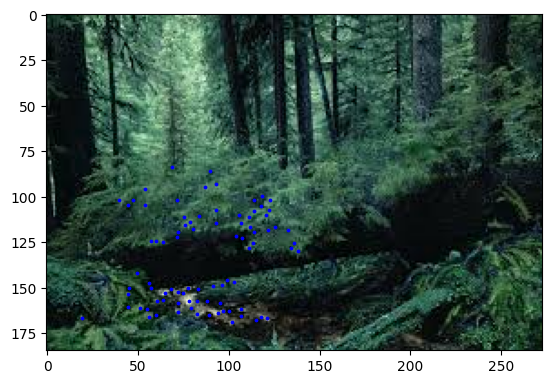

initial_scale 0.7030648074801159
Scale:  75.13970367338452 106.87450555617467


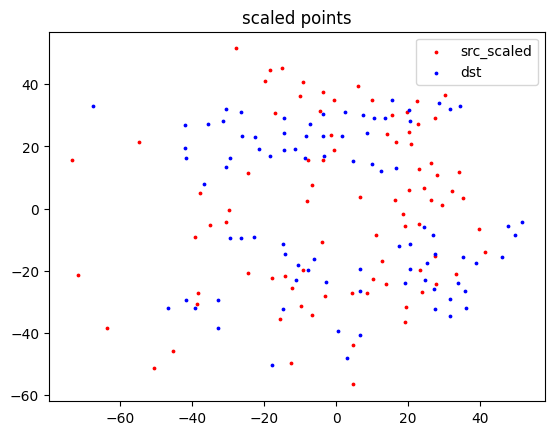

IndexError: boolean index did not match indexed array along axis 0; size of axis is 63 but size of corresponding boolean axis is 85

In [1]:
# 한 번 추적해가며 디버깅 해보기
from img_class.background_img import BackgroundImg
from img_class.object_img import ObjectImg
from utils.shape_match_utils import compute_refined_score, interpolate_feature_scores, visualize_results, ransac_affine, stable_affine
import time

DEBUG = True
obj_img = ObjectImg("apple.jpg")
back_img = BackgroundImg("forest.jpg")
if DEBUG:
    print("[WARNING] DEBUG MODE: YOU ARE IN DEBUG MODE. PLEASE debug=False IN PRODUCTION.")

# debug settings.
obj_img.set_method_debug("set_orb", debug=False)
obj_img.set_method_debug("set_pca", debug=DEBUG)
obj_img.set_method_debug("set_histogram", debug=DEBUG)
back_img.set_method_debug("set_orb", debug=False)
back_img.set_method_debug("set_pca", debug=DEBUG)
back_img.set_method_debug("set_histograms", debug=DEBUG)

obj_img.set_orb(nfeatures=300, nms_distance=5)
back_img.set_orb(nfeatures=1000, nms_distance=3)

N = obj_img.get_kp_length()
M = back_img.get_kp_length()
T = 8
NUM_OF_CANDIDATES = 10
if DEBUG:
    print(f"object keypoints: {N}, background keypoints: {M}, T: {T}")

obj_img.set_pca()
back_img.set_pca(N, T)

obj_img.set_histogram()
back_img.set_histograms()
if DEBUG:
    t1 = time.time()
scores = [compute_refined_score(back_img, obj_img, m, scale_weight=0.3) for m in range(M)]
if DEBUG:
    t2 = time.time()
    print(f"elapsed time in compute_refined_scores: {t2 - t1}")

print(min(scores), max(scores))

candidate_indices = back_img.get_candidates_indices(scores, NUM_OF_CANDIDATES)
print(f"candidate_indices: {candidate_indices}")
# affine_matrix = ransac_affine(back_img, obj_img, candidate_indices, 1000, mad_factor=1, mad_threshold=1)
# print(affine_matrix)
affine_matrix = stable_affine(back_img, obj_img, candidate_indices)



# For score visualization
# X, Y, Z = interpolate_feature_scores(back_img, scores)
# print(Z)
# visualize_results(X, Y, Z, back_img)

